In [260]:
import requests #(talk to API, dowload JSON)
import pandas as pd # turn json into tables(dataframe)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
!pip install pandasql
import pandasql as ps
import plotly.express as px
import folium
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


Tiny helper to fetch JSON **safely**

In [226]:
BASE = "https://api.spacexdata.com/v4"

def get_json(endpoint):
  url = f"{BASE}/{endpoint}"
  r = requests.get(url, timeout=30)
  r.raise_for_status()
  return r.json()

**Grab the raw tables we need**

In [227]:
#All launches (we’ll filter to past + Falcon 9)
launches = get_json("launches")

# 2) Lookups to translate IDs -> names/details

rockets     = get_json("rockets")
launchpads  = get_json("launchpads")
payloads    = get_json("payloads")
landpads    = get_json("landpads")    # where boosters land (drone ship, LZ)


**TURN list into fast lookup dictionaries**
The API gives IDs; we want human names (e.g., “Falcon 9”, “CCAFS SLC 40”, “ASDS”).

In [228]:
rocket_name = {r["_id"] if "_id" in r else r["id"]: r["name"] for r in rockets}

launchpad_name = {lp["_id"] if "_id" in lp else lp["id"]: lp["name"] for lp in launchpads}

# Landpad ID -> Landpad Name (drone ship / landing zone)
landpad_name = {ld["_id" if "_id" in ld else "id"]: ld["name"] for ld in landpads}

# Payload ID -> {mass_kg, orbit}
payload_info = {}
for p in payloads:
    pid = p["_id"] if "_id" in p else p["id"]
    payload_info[pid] = {
        "mass_kg": p.get("mass_kg"),
        "orbit":   p.get("orbit")
    }

**Put launches into a DataFrame and keep only what we need**

In [229]:
dfl = pd.json_normalize(launches)

# Keep only past launches (not upcoming)
if "upcoming" in dfl.columns:
    dfl = dfl.loc[~dfl["upcoming"]].copy()

**Keep ONLY Falcon 9 launches**

In [230]:
dfl["rocket_name"] = dfl["rocket"].map(rocket_name)
dfl = dfl[dfl["rocket_name"] == "Falcon 9"].copy()


**Helper functions to build features per launch**

In [231]:
def safe_first(lst, default=None):
    return lst[0] if isinstance(lst, list) and len(lst) else default

def total_payload_mass(payload_ids):
    masses = []
    for pid in (payload_ids or []):
        info = payload_info.get(pid, {})
        m = info.get("mass_kg")
        if m is not None:
            masses.append(m)
    return float(np.sum(masses)) if masses else np.nan

def primary_orbit(payload_ids):
    orbits = [payload_info.get(pid, {}).get("orbit") for pid in (payload_ids or [])]
    orbits = [o for o in orbits if o]
    # choose the first orbit (good enough) or most common:
    return orbits[0] if orbits else None

def landpad_readable(core_entry):
    # core_entry is a dict inside launch["cores"]
    if not isinstance(core_entry, dict):
        return None
    lid = core_entry.get("landpad")
    if not lid:
        return None
    # handle id / _id differences
    return landpad_name.get(lid) or landpad_name.get(lid.replace("_", "")) or lid


**Build the final, tidy dataset**

In [232]:
rows = []

for _, row in dfl.iterrows():
    # First stage info lives in the first element of "cores"
    cores_list = row.get("cores", [])
    core0 = safe_first(cores_list, default={})

    landing_success = core0.get("landing_success")
    # Some launches have None (no landing attempt) – we’ll keep them only if you want;
    # for modeling, we usually drop rows where target is None.

    rows.append({
        "flight_name":     row.get("name"),
        "date_utc":        row.get("date_utc"),
        "year":            pd.to_datetime(row.get("date_utc")).year if row.get("date_utc") else None,
        "launch_site":     launchpad_name.get(row.get("launchpad"), row.get("launchpad")),
        "rocket_name":     row.get("rocket_name"),
        "payload_mass_kg": total_payload_mass(row.get("payloads")),
        "orbit":           primary_orbit(row.get("payloads")),
        "reused":          core0.get("reused"),
        "landing_type":    core0.get("landing_type"),  # e.g., ASDS, RTLS
        "landing_site":    landpad_readable(core0),
        "landing_success": landing_success             # <-- TARGET (1/0/None)
    })

df = pd.DataFrame(rows)


Clean up (keep only rows with a real target)

For classification we need True/False (or 1/0). We’ll drop launches where there was no landing attempt (landing_success is None).

In [233]:
# Keep only rows where landing_success is True/False (not NaN/None)
df = df[df["landing_success"].isin([True, False])].copy()

# Convert booleans to 1/0
df["landing_success"] = df["landing_success"].astype(int)

# Optional: tidy types / fill small gaps
df["reused"] = df["reused"].fillna(False).astype(int)        # reused -> 1/0
df["payload_mass_kg"] = pd.to_numeric(df["payload_mass_kg"], errors="coerce")


In [234]:
df.to_csv("spacex_falcon9_landing_dataset.csv", index=False)
df_copy = df.copy()
print("Saved: spacex_falcon9_landing_dataset.csv")

Saved: spacex_falcon9_landing_dataset.csv


In [235]:
df.head()

,flight_name,date_utc,year,launch_site,rocket_name,payload_mass_kg,orbit,reused,landing_type,landing_site,landing_success
5,CASSIOPE,2013-09-29T16:00:00.000Z,2013,VAFB SLC 4E,Falcon 9,500.0,PO,0,Ocean,None,0
8,CRS-3,2014-04-18T19:25:00.000Z,2014,CCSFS SLC 40,Falcon 9,2296.0,ISS,0,Ocean,None,1
9,OG-2 Mission 1,2014-07-14T15:15:00.000Z,2014,CCSFS SLC 40,Falcon 9,1316.0,LEO,0,Ocean,None,1
12,CRS-4,2014-09-21T05:52:00.000Z,2014,CCSFS SLC 40,Falcon 9,2216.0,ISS,0,Ocean,None,0
13,CRS-5,2015-01-10T09:47:00.000Z,2015,CCSFS SLC 40,Falcon 9,2395.0,ISS,0,ASDS,JRTI-1,0


In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 5 to 178
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   flight_name      153 non-null    object 
 1   date_utc         153 non-null    object 
 2   year             153 non-null    int64  
 3   launch_site      153 non-null    object 
 4   rocket_name      153 non-null    object 
 5   payload_mass_kg  133 non-null    float64
 6   orbit            152 non-null    object 
 7   reused           153 non-null    int64  
 8   landing_type     153 non-null    object 
 9   landing_site     146 non-null    object 
 10  landing_success  153 non-null    int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 18.4+ KB


**Data Wrangling Step:**

In [237]:
df.shape

(153, 11)

In [238]:
df.isnull().sum()

,0
flight_name,0
date_utc,0
year,0
launch_site,0
rocket_name,0
payload_mass_kg,20
orbit,1
reused,0
landing_type,0
landing_site,7


In [239]:
# Fill missing payloads with average or 0
df['payload_mass_kg'] = df['payload_mass_kg'].fillna(df['payload_mass_kg'].mean())

# Replace missing landing sites with 'Unknown'
df['landing_site'] = df['landing_site'].fillna('Unknown')

# Replace missing orbit with 'Unknown'
df['orbit'] = df['orbit'].fillna('Unknown')

df.isnull().sum()


,0
flight_name,0
date_utc,0
year,0
launch_site,0
rocket_name,0
payload_mass_kg,0
orbit,0
reused,0
landing_type,0
landing_site,0


In [240]:
df_copy.head()

,flight_name,date_utc,year,launch_site,rocket_name,payload_mass_kg,orbit,reused,landing_type,landing_site,landing_success
5,CASSIOPE,2013-09-29T16:00:00.000Z,2013,VAFB SLC 4E,Falcon 9,500.0,PO,0,Ocean,None,0
8,CRS-3,2014-04-18T19:25:00.000Z,2014,CCSFS SLC 40,Falcon 9,2296.0,ISS,0,Ocean,None,1
9,OG-2 Mission 1,2014-07-14T15:15:00.000Z,2014,CCSFS SLC 40,Falcon 9,1316.0,LEO,0,Ocean,None,1
12,CRS-4,2014-09-21T05:52:00.000Z,2014,CCSFS SLC 40,Falcon 9,2216.0,ISS,0,Ocean,None,0
13,CRS-5,2015-01-10T09:47:00.000Z,2015,CCSFS SLC 40,Falcon 9,2395.0,ISS,0,ASDS,JRTI-1,0


**Convert Categories into Numbers (One-Hot Encoding)**

In [241]:
df.head()

,flight_name,date_utc,year,launch_site,rocket_name,payload_mass_kg,orbit,reused,landing_type,landing_site,landing_success
5,CASSIOPE,2013-09-29T16:00:00.000Z,2013,VAFB SLC 4E,Falcon 9,500.0,PO,0,Ocean,Unknown,0
8,CRS-3,2014-04-18T19:25:00.000Z,2014,CCSFS SLC 40,Falcon 9,2296.0,ISS,0,Ocean,Unknown,1
9,OG-2 Mission 1,2014-07-14T15:15:00.000Z,2014,CCSFS SLC 40,Falcon 9,1316.0,LEO,0,Ocean,Unknown,1
12,CRS-4,2014-09-21T05:52:00.000Z,2014,CCSFS SLC 40,Falcon 9,2216.0,ISS,0,Ocean,Unknown,0
13,CRS-5,2015-01-10T09:47:00.000Z,2015,CCSFS SLC 40,Falcon 9,2395.0,ISS,0,ASDS,JRTI-1,0


In [242]:
df = pd.get_dummies(df, columns=['orbit', 'launch_site', 'landing_type', 'landing_site'], drop_first=True)


In [243]:
# Drop columns not needed for ML
df = df.drop(columns=['flight_name', 'date_utc', 'rocket_name'], errors='ignore')

print(df.head())


    year  payload_mass_kg  reused  landing_success  orbit_GEO  orbit_GTO  \
5   2013            500.0       0                0      False      False   
8   2014           2296.0       0                1      False      False   
9   2014           1316.0       0                1      False      False   
12  2014           2216.0       0                0      False      False   
13  2015           2395.0       0                0      False      False   

    orbit_HEO  orbit_ISS  orbit_LEO  orbit_MEO  ...  launch_site_KSC LC 39A  \
5       False      False      False      False  ...                   False   
8       False       True      False      False  ...                   False   
9       False      False       True      False  ...                   False   
12      False       True      False      False  ...                   False   
13      False       True      False      False  ...                   False   

    launch_site_VAFB SLC 4E  landing_type_Ocean  landing_type_RTLS  

**Exploratory Data Analysis (EDA):**

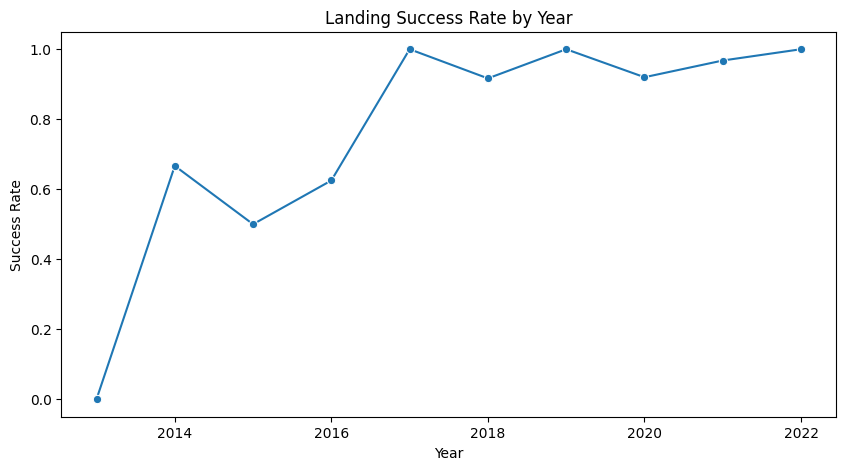

In [244]:
# Launch Success Over Time (by Year)
success_by_year = df.groupby('year')['landing_success'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(x='year', y='landing_success', data=success_by_year, marker='o')
plt.title("Landing Success Rate by Year")
plt.ylabel("Success Rate")
plt.xlabel("Year")
plt.show()


**Payload Mass vs. Success**

/tmp/ipython-input-2671943786.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




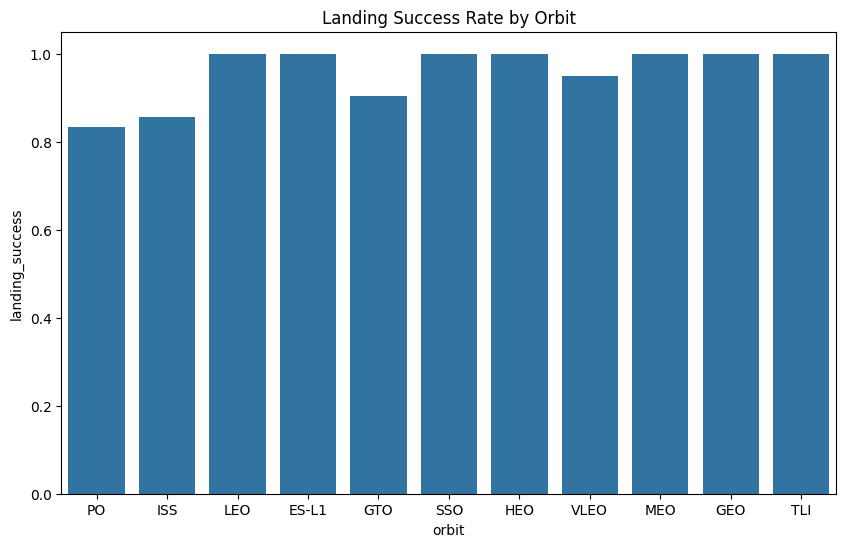

In [246]:
plt.figure(figsize=(10,6))
sns.barplot(x='orbit', y='landing_success', data=df_copy, ci=None)
plt.title("Landing Success Rate by Orbit")
plt.show()

In [247]:
import pandasql as ps

def run_query(query):
    return ps.sqldf(query, globals())

# SQL query as a string
query = """
SELECT launch_site, COUNT(*) as total_launches
FROM df_copy
GROUP BY launch_site
ORDER BY total_launches DESC;
"""

# run it
result = run_query(query)
print(result)


    launch_site  total_launches
0  CCSFS SLC 40              80
1    KSC LC 39A              48
2   VAFB SLC 4E              25


**Success rate by orbit**

In [248]:
query = """
SELECT orbit, AVG(landing_success) as success_rate
FROM df_copy
GROUP BY orbit
ORDER BY success_rate DESC;
"""
print(run_query(query))


    orbit  success_rate
0     TLI      1.000000
1     SSO      1.000000
2     MEO      1.000000
3     LEO      1.000000
4     HEO      1.000000
5     GEO      1.000000
6   ES-L1      1.000000
7    None      1.000000
8    VLEO      0.948276
9     GTO      0.904762
10    ISS      0.857143
11     PO      0.833333


**Average payload by launch site**

In [249]:
query = """
SELECT launch_site, AVG(payload_mass_kg) as avg_payload
FROM df_copy
GROUP BY launch_site
ORDER BY avg_payload DESC;
"""
print(run_query(query))


    launch_site   avg_payload
0    KSC LC 39A  10337.675676
1  CCSFS SLC 40   8427.242466
2   VAFB SLC 4E   7829.695652


.** Launches per year**

In [250]:
query = """
SELECT SUBSTR(year, 1, 4) as launch_year, COUNT(*) as launches
FROM df_copy
GROUP BY launch_year
ORDER BY launch_year;
"""
print(run_query(query))


  launch_year  launches
0        2013         1
1        2014         3
2        2015         4
3        2016         8
4        2017        15
5        2018        12
6        2019        10
7        2020        25
8        2021        31
9        2022        44


**Interactive Visual Analytics:**
Folium is a Python library that lets you plot points on real-world maps.

You give it latitude and longitude.

It places markers (like Google Maps pins).

Example: showing all SpaceX launch sites in Florida & California.

In [251]:
# creat a dictionary manually for latitude and longitude
# Create dictionary for site coordinates
site_coords = {
    'CCAFS SLC 40': [28.5619, -80.5774],
    'KSC LC 39A': [28.5733, -80.6469],
    'VAFB SLC 4E': [34.6321, -120.6106],
    'Boca Chica LC': [25.9972, -97.1566]
}



In [252]:
# Part 1: Maps with Folium (for launch sites)

# Start map centered on USA
site_map = folium.Map(location=[30, -95], zoom_start=4)

# Add markers for each launch site
for site, coords in site_coords.items():
    folium.Marker(
        location=coords,
        popup=site,
        icon=folium.Icon(color="blue", icon="rocket", prefix="fa")
    ).add_to(site_map)

site_map




Plotly (and Dash) let you build interactive dashboards:

**Instead of static charts, users can zoom, hover, filter.**

**Example**:

Bar chart of success rate per orbit.
Scatter chart of payload vs landing success, colored by orbit.
Interactive line chart of launches per year.

In [253]:
#Launch Success by Orbit (Bar Chart)
fig = px.bar(
    df_copy.groupby("orbit")["landing_success"].mean().reset_index(),
    x="orbit",
    y="landing_success",
    title="Landing Success Rate by Orbit",
    text="landing_success"
)
fig.show()


In [254]:
#Payload vs Success (Scatter Plot)
fig = px.scatter(
    df_copy,
    x="payload_mass_kg",
    y="landing_success",
    color="orbit",
    hover_data=["launch_site"],
    title="Payload Mass vs Landing Success"
)
fig.show()


In [255]:
#Launches per Year (Line Chart)
df_copy['year'] = pd.to_datetime(df_copy['date_utc']).dt.year

fig = px.line(
    df_copy.groupby("year").size().reset_index(name="launches"),
    x="year",
    y="launches",
    title="Launches per Year"
)
fig.show()


**Now time for train the model**
#first split the dataset

In [256]:
X = df.drop("landing_success", axis=1)

y = df['landing_success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
df.head()

,year,payload_mass_kg,reused,landing_success,orbit_GEO,orbit_GTO,orbit_HEO,orbit_ISS,orbit_LEO,orbit_MEO,...,launch_site_KSC LC 39A,launch_site_VAFB SLC 4E,landing_type_Ocean,landing_type_RTLS,landing_site_JRTI,landing_site_JRTI-1,landing_site_LZ-1,landing_site_LZ-4,landing_site_OCISLY,landing_site_Unknown
5,2013,500.0,0,0,False,False,False,False,False,False,...,False,True,True,False,False,False,False,False,False,True
8,2014,2296.0,0,1,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,True
9,2014,1316.0,0,1,False,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,True
12,2014,2216.0,0,0,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,True
13,2015,2395.0,0,0,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False


In [257]:
# initialize the model and train them
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained successfully!")

Logistic Regression trained successfully!
Decision Tree trained successfully!
Random Forest trained successfully!
SVM trained successfully!


In [258]:
#tests the model

In [262]:
import pandas as pd

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.934783   0.934783  1.000000  0.966292
1        Decision Tree  0.782609   0.945946  0.813953  0.875000
2        Random Forest  0.804348   0.947368  0.837209  0.888889
3                  SVM  0.934783   0.934783  1.000000  0.966292


In [263]:
import plotly.express as px

# Melt dataframe for plotting
results_melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Interactive bar chart
fig = px.bar(
    results_melted,
    x="Model", y="Score", color="Metric",
    barmode="group",
    title="Model Performance Comparison"
)
fig.show()
